# Homework 7

In ordinary supervised learning, a model learns to represent categories using labeled instances of the categories. The features that characterize a "tweet about customer service" are learned directly from examples of those tweets.

"Zero-shot classification" relies on previously learned representations. (In the case of CLIP, for instance, the model has already learned a set of *general* relations between images and words.) So we can *transfer* that learning to a new task, and ask CLIP to recognize an arbitrary category like "posters of a romantic movie" without showing it examples of the category.

This is nice, but how accurate is it really? Can CLIP's zero-shot classification ability compete with supervised models that were directly trained on the categories they're being asked to recognize?

This homework asks you to run a simple experiment to find out.

The early stages of the notebook will repeat some of the preparation we ran last time, just to set up the model.

The homework assignment itself is quite brief, and is located at the bottom of the notebook with the header "Homework Assignment." When you print out the .pdf to hand it in, it's fine (and in fact encouraged) to delete the first N pages of the pdf before you get to the assignment. Unless you do something different there than the set-up below, there's no need to include it, and it will be easier to grade if you cut to the chase.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=e521a5116fbb7973e68a0e8d9c70f463f7860dcbce230aafadff6b5ac604c0c5
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dt5nmh3j
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-dt5nmh3j
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369090 sha256=a2509e7474179c090fc138658e1a5b6a3b8b5b2f222712f604539733d938de16
  Stored in directory: /tmp/pip-ephem-wheel-cache-9cpk1mzg/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.9.0+cu111


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 119MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f311c58f320>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

*You don't really have to run this cell; it's just here to illustrate and help you understand what's happening.*

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
import os
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load CIFAR data

We load the CIFAR images that we're going to classify.

In [8]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


Let's get comfortable with some of the attributes of the ```cifar100``` object we just created. Most importantly it has "data" (a list of the actual images) and "targets" (a list of the categories the images belong to, stored as integers). The "classes" are category names.

The code below uses the __dict__ attribute to find other attributes of cifar100, and prints the length of each attribute. For instance there are 50,000 photos in "data," and 50,000 class labels in "targets."

In [15]:
for key in cifar100.__dict__:
  try:
    print(key, len(getattr(cifar100, key)))
  except:
    pass

root 12
data 50000
targets 50000
classes 100
class_to_idx 100


# What if we tried to categorize CIFAR images using the CIFAR labels?

The CIFAR images have been loaded as ordinary numpy arrays, but the "preprocess" function that crops them and sizes them appropriately for CLIP expects PIL "Image" objects, so we convert them into "Images" before preprocessing.


In [18]:
image_input = torch.tensor(np.stack([preprocess(Image.fromarray(x)) for x in cifar100.data[0:8]])).cuda()
# Notice the [0: 8] part; that's where we decide to consider only the first eight pictures.

To generate textual descriptions of the images, we rely on the fact that cifar100 has a list of "targets" (integers that indicate the class of the corresponding image). These can be converted into text using the list of classes that is also in cifar100.

In [19]:
print('Classes in order:', cifar100.classes[0:10])
print('Indices for the first eight pictures:', cifar100.targets[0:8])

text_tokens = clip.tokenize([f"This is a photo of a {cifar100.classes[label]}" for label in cifar100.targets[0:8]]).cuda()
# Notice the [0: 8] part; that's where we decide to consider only labels for the first 8 pictures.

Classes in order: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
Indices for the first eight pictures: [19, 29, 0, 11, 1, 86, 90, 28]


At this point "text_tokens" contains tokenized versions of sentences like "This is a photo of a x" for the first eight categories in "targets."

In the next part, we simply run the model to turn images and texts into vectors.

Then we compute cosine similarity by normalizing the vectors and taking their dot products.

In [20]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

Before computing cosine similarity, let's look at the tokenized version of a sentence, and the equivalent vector after "encoding" by CLIP.

In [38]:
print("Tokens:", text_tokens[0])
print("The encoded vector:", text_features[0])

Tokens: tensor([49406,   589,   533,   320,  1125,   539,   320, 13644, 49407,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')
The encoded vector: tensor([-4.8385e-03,  5.9172e-02, -3.9109e-03,  9.1593e-03, -8.0128e-03,
        -3.5133e-02, -4.2135e-02, -6.0947e-02,  5.7353e-03, -2.1326e-02,
        -3.0178e-02,  4.7245e-03, -1.9416e-02,  3.9127e-02,  2.4248e-02,
        -1.2574e-02,  1.0688e-02,  1.0620e-02, -6.1052e-03, -1.0679e-03,
         3.2692e-02, -3.6193e-02,  5.2219e-02,  2.3262e-02,

You can see that the "tokens" are basically a short list of integers corresponding to words and word-parts.

The encoded vector is something a lot more difficult to describe: a series of real numbers that define a point in 512-dimensional space.

Normalize the vectors and take the dot products between text vectors and image vectors. This will give us "cosine similarity."

In [21]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

array([[0.27343854, 0.24354902, 0.23996344, 0.20256205, 0.22570324,
        0.21436775, 0.19859326, 0.22116137],
       [0.20896651, 0.29010996, 0.2396757 , 0.2108997 , 0.23766588,
        0.22087982, 0.21547124, 0.2302053 ],
       [0.21389522, 0.20332938, 0.29501492, 0.20362422, 0.2136738 ,
        0.2287674 , 0.20162062, 0.22173744],
       [0.21677352, 0.21824509, 0.22865978, 0.25673202, 0.21470883,
        0.2268345 , 0.21595459, 0.21645582],
       [0.19481009, 0.2321414 , 0.23736928, 0.21948716, 0.24718054,
        0.24059208, 0.2150034 , 0.23179403],
       [0.2107875 , 0.20027305, 0.24425565, 0.21207994, 0.21074258,
        0.2335948 , 0.20300427, 0.22756481],
       [0.2085711 , 0.19612843, 0.22175711, 0.1906318 , 0.20371813,
        0.219519  , 0.28274012, 0.19507964],
       [0.20238867, 0.19091022, 0.22442591, 0.18762751, 0.19815706,
        0.22920302, 0.18979326, 0.30402297]], dtype=float32)

The code below just visualizes the similarity matrix. It is largely unchanged from our lab.

Text(0.5, 1.0, 'Cosine similarity between text and image features')

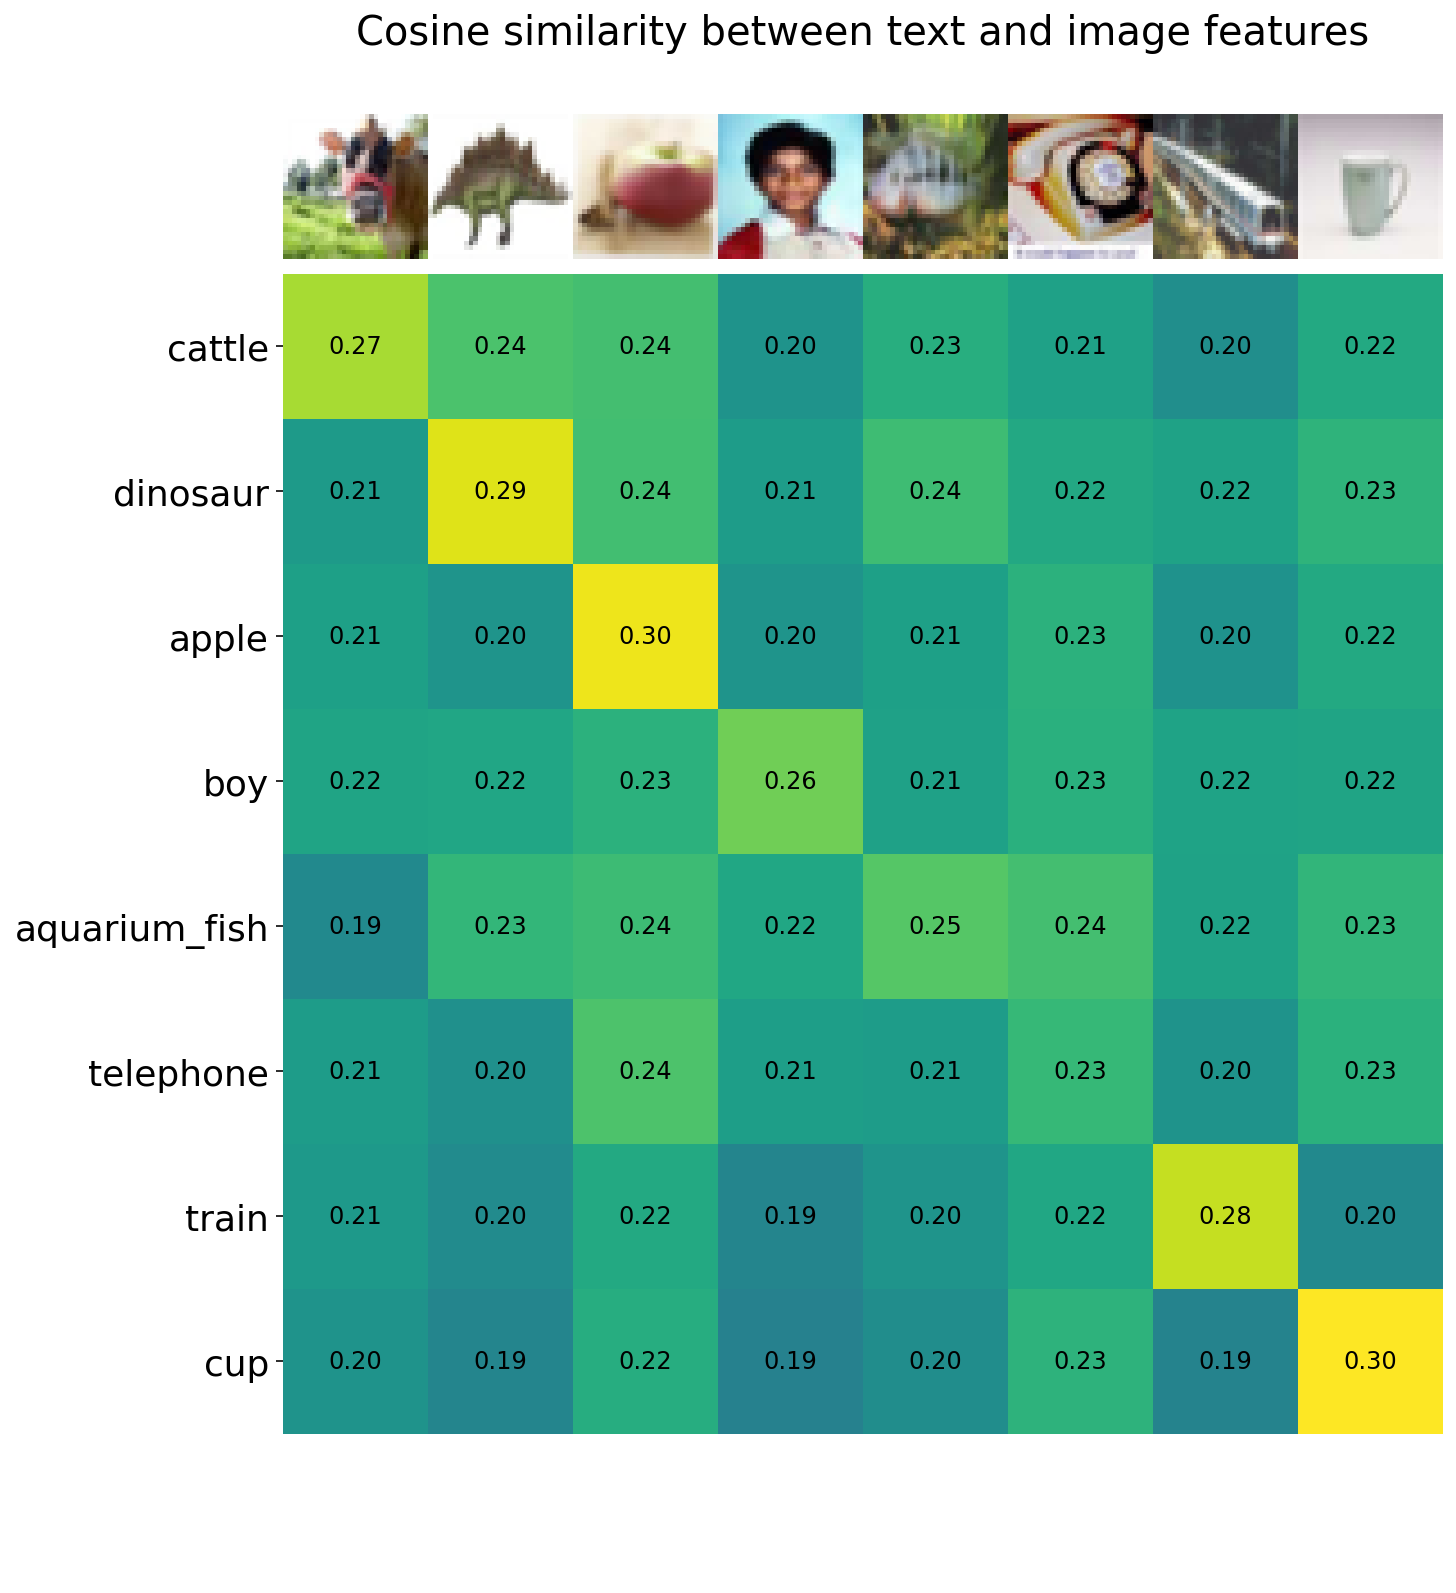

In [22]:
count = 8
cifar_descriptions = [cifar100.classes[x] for x in cifar100.targets[0:8]]

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), cifar_descriptions, fontsize=18)
plt.xticks([])
for i, image in enumerate(cifar100.data[0:8]):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Let's compare the first eight photos to descriptions of all 100 categories

We want to move from this demonstration example to an actual measure of classification accuracy.

In the example above, we only checked the eight categories that we knew matched the first eight photos. But we can also compare the first eight photos to all 100 categories.

In [27]:
all_100_text_tokens = clip.tokenize([f"This is a photo of a {cifar100.classes[label]}" for label in range(0, 100)]).cuda()

The code above creates "tokens" for 100 sentences.

The code below turns them into encoded vectors, and calculates the similarity matrix for 100 sentences with the 8 images we've been using (the first eight images in CIFAR100).

In [35]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(all_100_text_tokens).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [40]:
similarity.shape

(100, 8)

Note that the similarity matrix has 100 rows (for all 100 possible classes), and only 8 columns (for the 8 photos we're classifying).

Below we find the closest category for each of those eight photos. Notice that the telephone is misclassified, and is assigned to a category that wasn't in the matrix above.

Notice also, particularly, how we can test whether a photo has been correctly classified.

In [41]:
for i in range(0, 8):
  similar2photo = similarity[ : , i]
  most_similar = np.argmax(similar2photo) # The numpy argmax method gives us the index of the
                                          # largest value in a numpy array. So, in this case,
                                          # 
  print(most_similar, cifar100.classes[most_similar], most_similar == cifar100.targets[i])

41 lawn_mower False
29 dinosaur True
0 apple True
11 boy True
1 aquarium_fish True
83 sweet_pepper False
90 train True
28 cup True


# Homework assignment

How accurate is CLIP at zero-shot classification of the first 500 photos in CIFAR?

You can report accuracy simply as the percentage of photos in the first 500 that are assigned to the correct class, using the method above.

Be sure that you're comparing images to all 100 classes, and normalizing the vectors before calculating the dot products.

For reference, the current state-of-the-art on this dataset is 96.08% accuracy. But when [people first started trying in 2013](https://paperswithcode.com/sota/image-classification-on-cifar-100) 60% was good.